In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skimage
from skimage import io, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage import io, measure, color, img_as_ubyte, exposure
from skimage.color import label2rgb
import pandas as pd
import warnings

In [2]:
# Generate random data
np.random.seed(42)
n_points = 100
x = np.random.rand(n_points)
y = np.random.rand(n_points)
z = np.random.rand(n_points)

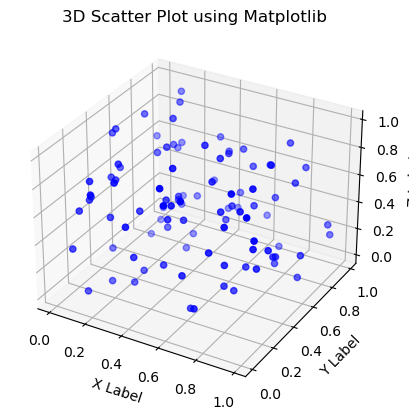

In [3]:
# Create a 3D scatter plot using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('3D Scatter Plot using Matplotlib')
plt.show()

<img src="шлифы\image_thresholding.jpg" alt="image" width="600"/>

In [4]:
# Specify the folder containing the mask images
image_folder = '.\шлифы\masks'
output_folder = '.\шлифы\processed_masks'  # Folder to save processed images

# Load all mask images from the specified folder
mask_stack = io.imread(image_folder + '/masks.tif')

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

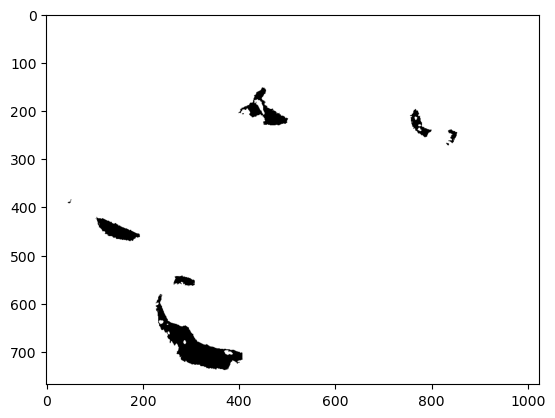

In [5]:
plt.imshow(mask_stack[11] > 50, cmap="gray")

In [6]:
total_pores_areas = []
rel_pores_areas = []
for i, mask in enumerate(mask_stack):
    # Making pores True
    processed_mask = ~(mask > 50)

    # Calculate total pores area
    labeled_mask = measure.label(processed_mask)
    region_props = measure.regionprops(labeled_mask)

    total_area = 0
    for region in region_props:
        total_area += region.area
    total_pores_areas.append(total_area)
    rel_pores_areas.append(total_area / (processed_mask.shape[0] * processed_mask.shape[1]) * 100)
    # Color all labels into one
    colored_labels = label2rgb(labeled_mask, bg_label=0)
    # Disable the warning about low contrast
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Save the processed image
        output_path = os.path.join(output_folder, f"processed_mask_{i}.png")
        io.imsave(output_path, img_as_ubyte(colored_labels))

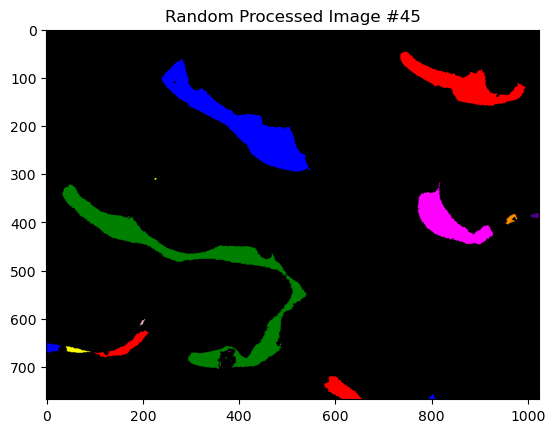

In [7]:
# Display a random image
rand_idx = np.random.randint(len(mask_stack))
random_image = io.imread(os.path.join(output_folder, f"processed_mask_{rand_idx}.png"))
plt.imshow(random_image)
plt.title(f"Random Processed Image #{rand_idx+1}")
plt.show()

In [8]:
layer_data = pd.read_excel('Layer_thickness_porosity.xlsx',  sheet_name='Sheet1')
layer_data.head()

,t,porosity,density,power,V,Hatch,E
0,30,0.000,100.000,300,150,80,833.333333
1,50,0.000,100.000,300,150,80,500.000000
2,70,0.455,99.545,300,150,80,357.142857
3,90,0.480,99.520,300,150,80,277.777778
4,110,6.697,93.303,300,150,80,227.272727


In [9]:
layer_data['porosity'] = rel_pores_areas
layer_data.head()

,t,porosity,density,power,V,Hatch,E
0,30,0.000636,100.000,300,150,80,833.333333
1,50,0.000000,100.000,300,150,80,500.000000
2,70,0.338618,99.545,300,150,80,357.142857
3,90,0.183233,99.520,300,150,80,277.777778
4,110,5.943553,93.303,300,150,80,227.272727


In [10]:
df = layer_data

<function matplotlib.pyplot.show(close=None, block=None)>

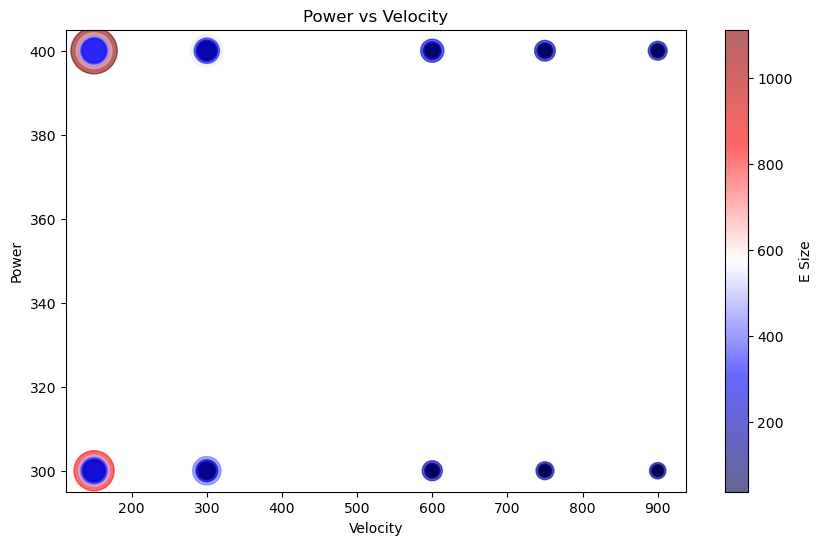

In [11]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['V'], df['power'], s=df['E'], c=df['E'], cmap='seismic', alpha=0.6)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('E Size')

# Set labels and title
plt.xlabel('Velocity')
plt.ylabel('Power')
plt.title('Power vs Velocity')
plt.show

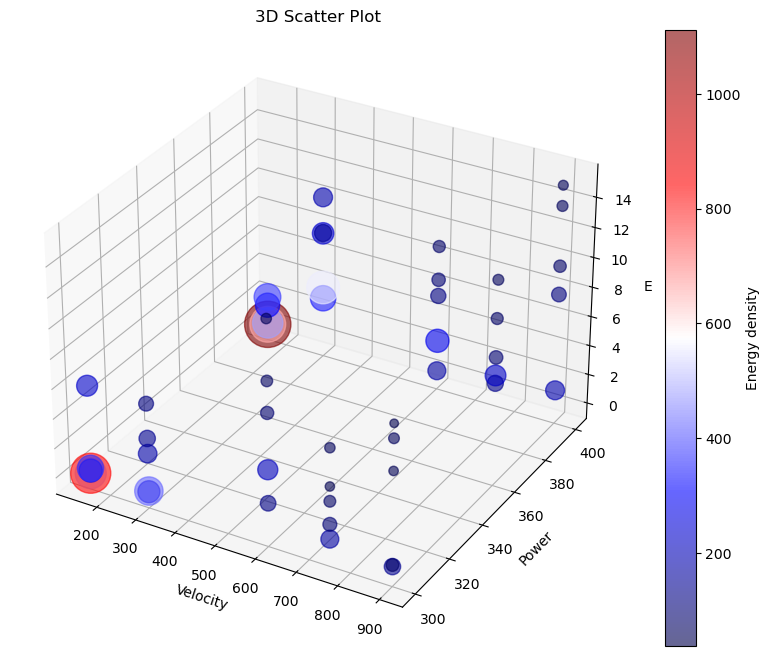

In [12]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['V'], df['power'], df['porosity'], s=df['E'], c=df['E'], cmap='seismic', alpha=0.6)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Energy density')

# Set labels and title
ax.set_xlabel('Velocity')
ax.set_ylabel('Power')
ax.set_zlabel('E')
ax.set_title('3D Scatter Plot')

plt.show()

In [13]:
from scipy.interpolate import griddata
df = df.fillna(df.apply(np.sqrt))

# Generate more points within each V interval
n_interp_points = 50  # Number of interpolated points between V values
interp_v = np.linspace(df['V'].min(), df['V'].max(), n_interp_points)
interp_power = np.linspace(df['power'].min(), df['power'].max(), n_interp_points)
interp_x, interp_y = np.meshgrid(interp_v, interp_power)

In [14]:
# Interpolate the 'porosity' column values to create an approximated surface
interp_z = griddata((df['V'], df['power']), df['porosity'], (interp_x, interp_y), method='cubic')

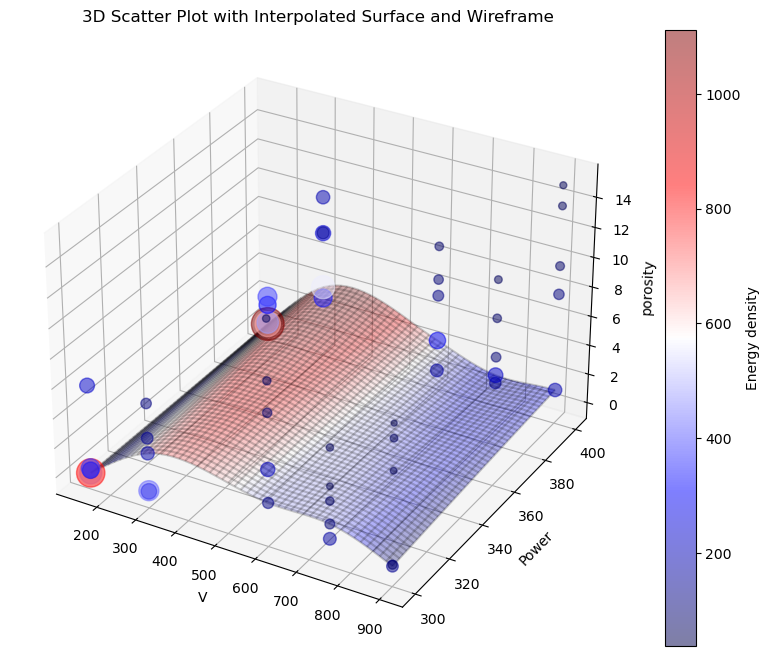

In [39]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['V'], df['power'], df['porosity'], s=df['E']*0.5, c=df['E'], cmap='seismic', alpha=0.5)

# Create a surface plot using the interpolated mesh grid
surface = ax.plot_surface(interp_x, interp_y, interp_z, cmap='seismic', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Energy density')

# Create wireframe overlay
wireframe = ax.plot_wireframe(interp_x, interp_y, interp_z, color='k', alpha=0.2)

# Set labels and title
ax.set_xlabel('V')
ax.set_ylabel('Power')
ax.set_zlabel('porosity')
ax.set_title('3D Scatter Plot with Interpolated Surface and Wireframe')

plt.show()

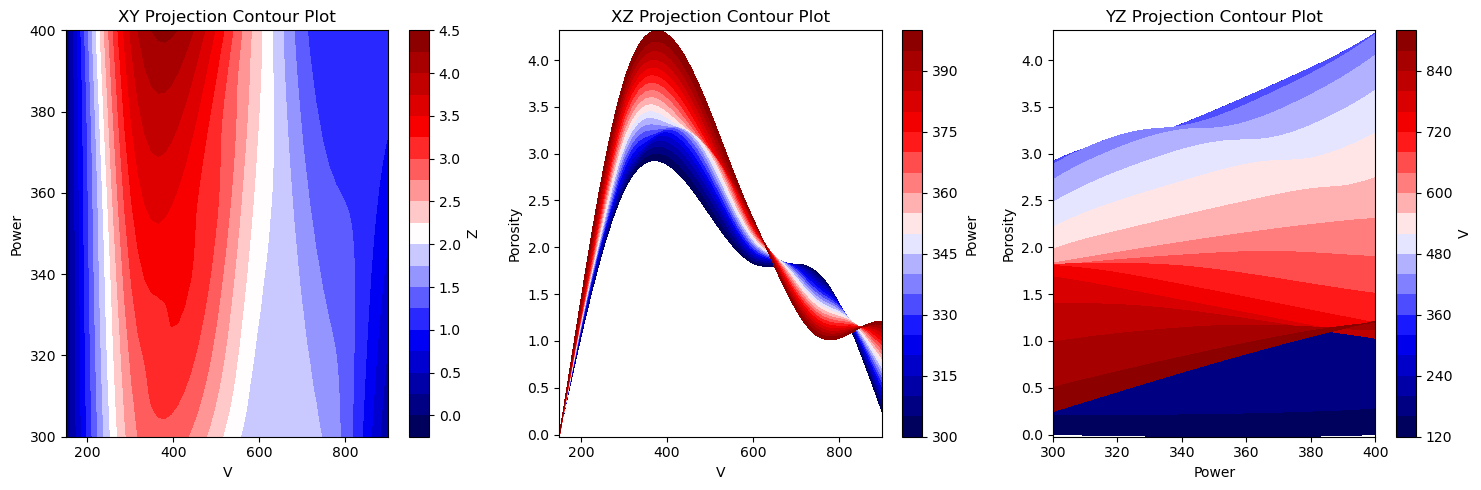

In [41]:
# Assuming df, interp_x, interp_y, interp_z are defined

# Create a 3D scatter plot
fig = plt.figure(figsize=(15, 5))

# XY Projection Contour Plot
ax1 = fig.add_subplot(131)
contour_xy = ax1.contourf(interp_x, interp_y, interp_z, cmap='seismic', levels=20)
ax1.set_xlabel('V')
ax1.set_ylabel('Power')
ax1.set_title('XY Projection Contour Plot')
cbar1 = plt.colorbar(contour_xy, ax=ax1)
cbar1.set_label('Z')

# XZ Projection Contour Plot
ax2 = fig.add_subplot(132)
contour_xz = ax2.contourf(interp_x, interp_z, interp_y, cmap='seismic', levels=20)
ax2.set_xlabel('V')
ax2.set_ylabel('Porosity')
ax2.set_title('XZ Projection Contour Plot')
cbar2 = plt.colorbar(contour_xz, ax=ax2)
cbar2.set_label('Power')

# YZ Projection Contour Plot
ax3 = fig.add_subplot(133)
contour_yz = ax3.contourf(interp_y, interp_z, interp_x, cmap='seismic', levels=20)
ax3.set_xlabel('Power')
ax3.set_ylabel('Porosity')
ax3.set_title('YZ Projection Contour Plot')
cbar3 = plt.colorbar(contour_yz, ax=ax3)
cbar3.set_label('V')

plt.tight_layout()
plt.show()


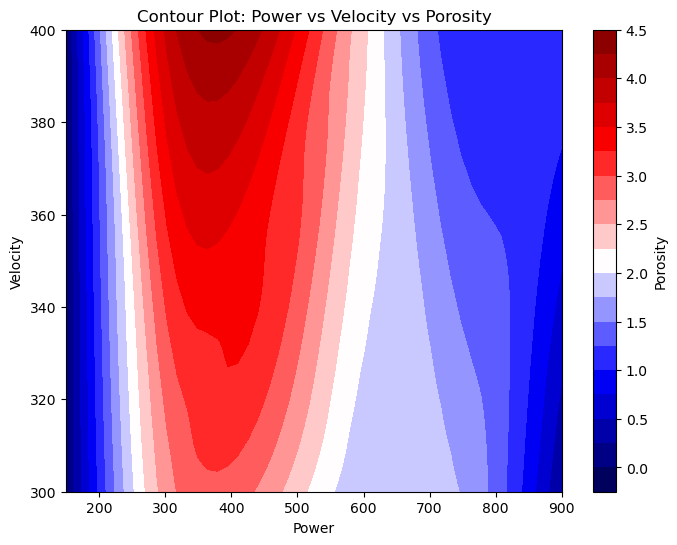

In [23]:
# Create the contour plot
plt.figure(figsize=(8, 6))

# Create the contour plot for the XY projection
contour = plt.contourf(interp_x, interp_y, interp_z, cmap='seismic', levels=20)
plt.colorbar(contour, label='Porosity')

plt.title('Contour Plot: Power vs Velocity vs Porosity')
plt.xlabel('Power')
plt.ylabel('Velocity')

plt.show()

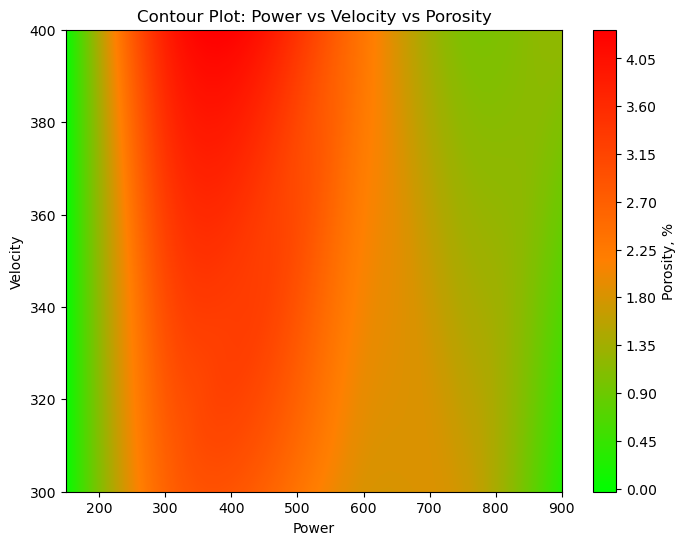

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the custom colormap
colors = [(0, 1, 0) , (1, 0.5, 0) , (1, 0, 0)]  # Green, Red, Orange
positions = [0, 0.5, 1]
custom_cmap = LinearSegmentedColormap.from_list('CustomColormap', list(zip(positions, colors)))

# Assuming df, interp_x, interp_y, interp_z are defined

# Create the contour plot
plt.figure(figsize=(8, 6))

# Create the filled contour plot using the custom colormap
# Levels are set to 300 to increase the resolution of the plot
contour = plt.contourf(interp_x, interp_y, interp_z, cmap=custom_cmap, levels=300)
plt.colorbar(contour, label='Porosity, %')

# Create the contour lines with black color and slight transparency
# contour_lines = plt.contour(interp_x, interp_y, interp_z, colors='black', linewidths=0.5, alpha=0.6)

plt.title('Contour Plot: Power vs Velocity vs Porosity')
plt.xlabel('Power')
plt.ylabel('Velocity')

plt.show()


In [45]:
# Export the interpolated data to a CSV file
interp_df = pd.DataFrame({'V': interp_x.flatten(), 'power': interp_y.flatten(), 'porosity': interp_z.flatten()})
interp_df.to_csv('interpolated_data.csv', index=False)

In [46]:
# Export df to a xlsx file
df.to_excel('layer_data.xlsx', index=False)